In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Required Imports

In [2]:
import os
import cv2
import gdcm
import numpy as np
import pydicom
import scipy
from matplotlib import pyplot, image
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import ndimage
from glob import glob
pyplot.style.available

['seaborn-dark-palette',
 'seaborn-paper',
 'seaborn-talk',
 'grayscale',
 'seaborn-deep',
 'seaborn-darkgrid',
 '_classic_test',
 'classic',
 'seaborn-dark',
 'seaborn-muted',
 'seaborn-whitegrid',
 'dark_background',
 'tableau-colorblind10',
 'fast',
 'seaborn',
 'seaborn-notebook',
 'Solarize_Light2',
 'seaborn-colorblind',
 'fivethirtyeight',
 'ggplot',
 'seaborn-ticks',
 'bmh',
 'seaborn-white',
 'seaborn-pastel',
 'seaborn-bright',
 'seaborn-poster']

# Plot Functions

In [3]:
# PEGAR DICOM E NAO PNG PARA FAZER O JANELAMENTO
def read_image(filepath):
    # Read grayscale DICOM image
    image = cv2.imread(filepath)
    return image

def generate_histogram(image):
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    return histogram

def save_processed_image(img, directory, filename):
    processed_filepath = directory + 'p-' + filename
    cv2.imwrite(processed_filepath, img)

def save_histogram(histogram, h_directory, filename):
    pyplot.figure(figsize=(4,4))
    pyplot.xlim([0, 250])
    pyplot.ylim([0, 400])
    pyplot.axis('on')
    pyplot.plot(histogram)
    pyplot.savefig(h_directory + "h-" + filename, bbox_inches=0)
    pyplot.close()
    
def plot_image(image):
    imgplot = pyplot.imshow(image, cmap=pyplot.cm.bone)
    
def plot_histogram(histogram):
    # configure and draw the histogram figure
    pyplot.figure()
    pyplot.title("Histograma de um corte axial de TC de crânio")
    pyplot.xlabel("valores em escala de cinza")
    pyplot.ylabel("número de pixels")
    pyplot.xlim([0, 256])
    # TODO: qual será o limite de y?
    pyplot.ylim([0, 400])
    pyplot.plot(histogram)
    pyplot.show()

# Image Processing Functions

In [4]:
def dcm_to_hu_224(dcm_path, xsize, ysize):
    dcm_data = pydicom.read_file(dcm_path)
    img = dcm_data.pixel_array
    data = get_hu_values(dcm_data)
    xscale = xsize/img.shape[0]; yscale = ysize/img.shape[1]
    return scipy.ndimage.interpolation.zoom(data, [xscale, yscale])

def get_hu_values(dcm_data):
    slope = float(dcm_data.RescaleSlope)
    intercept = float(dcm_data.RescaleIntercept)
    matrix = np.array(dcm_data.pixel_array)
    matrix = np.multiply(matrix, slope)
    matrix = np.add(matrix, intercept)
    return matrix

def create_channel(data, level, width):
    normalized = np.piecewise(data, [data <= (level -0.5 - (width - 1) / 2), data > (level - 0.5 + (width - 1) / 2)],
                                    [0, 255, lambda data: ((data - (level - 0.5)) / (width - 1) + 0.5) * (255 - 0)])
    return cv2.convertScaleAbs(normalized)

def remove_skull(dcm_hu, basic_window, ww, wl, b_low, b_upp):
    bone_mask = create_channel(dcm_hu, ww, wl)
    ret, bone_thresh = cv2.threshold(bone_mask, b_low, b_upp, 1)
    no_bone = np.bitwise_and(basic_window, bone_thresh, bone_thresh)
    return no_bone

# Remove ventricle pixels
def remove_ventricles(img):
    img[np.where((img <= 100).all(axis = 1))] = 0
    return img

def median_filter(img, value):
    img = ndimage.median_filter(img, value)
    return img

# Remove soft tissues using biggest contour
def remove_soft_tissues(img):
    biggest_contour, mask = find_biggest_contour(img)
    biggest_contour_image = np.bitwise_and(img, mask, mask)
    return biggest_contour_image, mask

# Returns image biggest_contour and mask
def find_biggest_contour(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Isolate largest contour
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    if contour_sizes == []: 
        biggest_contour = np.array([[0, 0]])
    else:
        biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
    return biggest_contour, mask 


# All Steps

In [5]:
def full_slice_process(dcm_path, ww, wl, filter_level, b_ww, b_wl, b_low, b_upp):
    ## windowing
    dcm_data = pydicom.read_file(dcm_path)
    img = dcm_data.pixel_array
    xsize = 224; ysize = 224;
    dcm_hu = dcm_to_hu_224(dcm_path, xsize, ysize)
    basic_window = create_channel(dcm_hu, ww, wl)
#     plt.imshow(basic_window, 'gray')
    no_bone = remove_skull(dcm_hu, basic_window, b_ww, b_wl,  b_low, b_upp)
#     plt.imshow(no_bone, 'gray')
#     img_no_ventricles = remove_ventricles(no_bone)

    img_median_filter = median_filter(no_bone, filter_level)

#     plt.imshow(img_median_filter, 'gray')
    img_no_soft_tissues, mask = remove_soft_tissues(img_median_filter)
#     plt.imshow(img_no_soft_tissues, 'gray')
    # final_img = isolate_hemorrhages(img_no_soft_tissues)
    return basic_window, no_bone, img_median_filter, img_no_soft_tissues

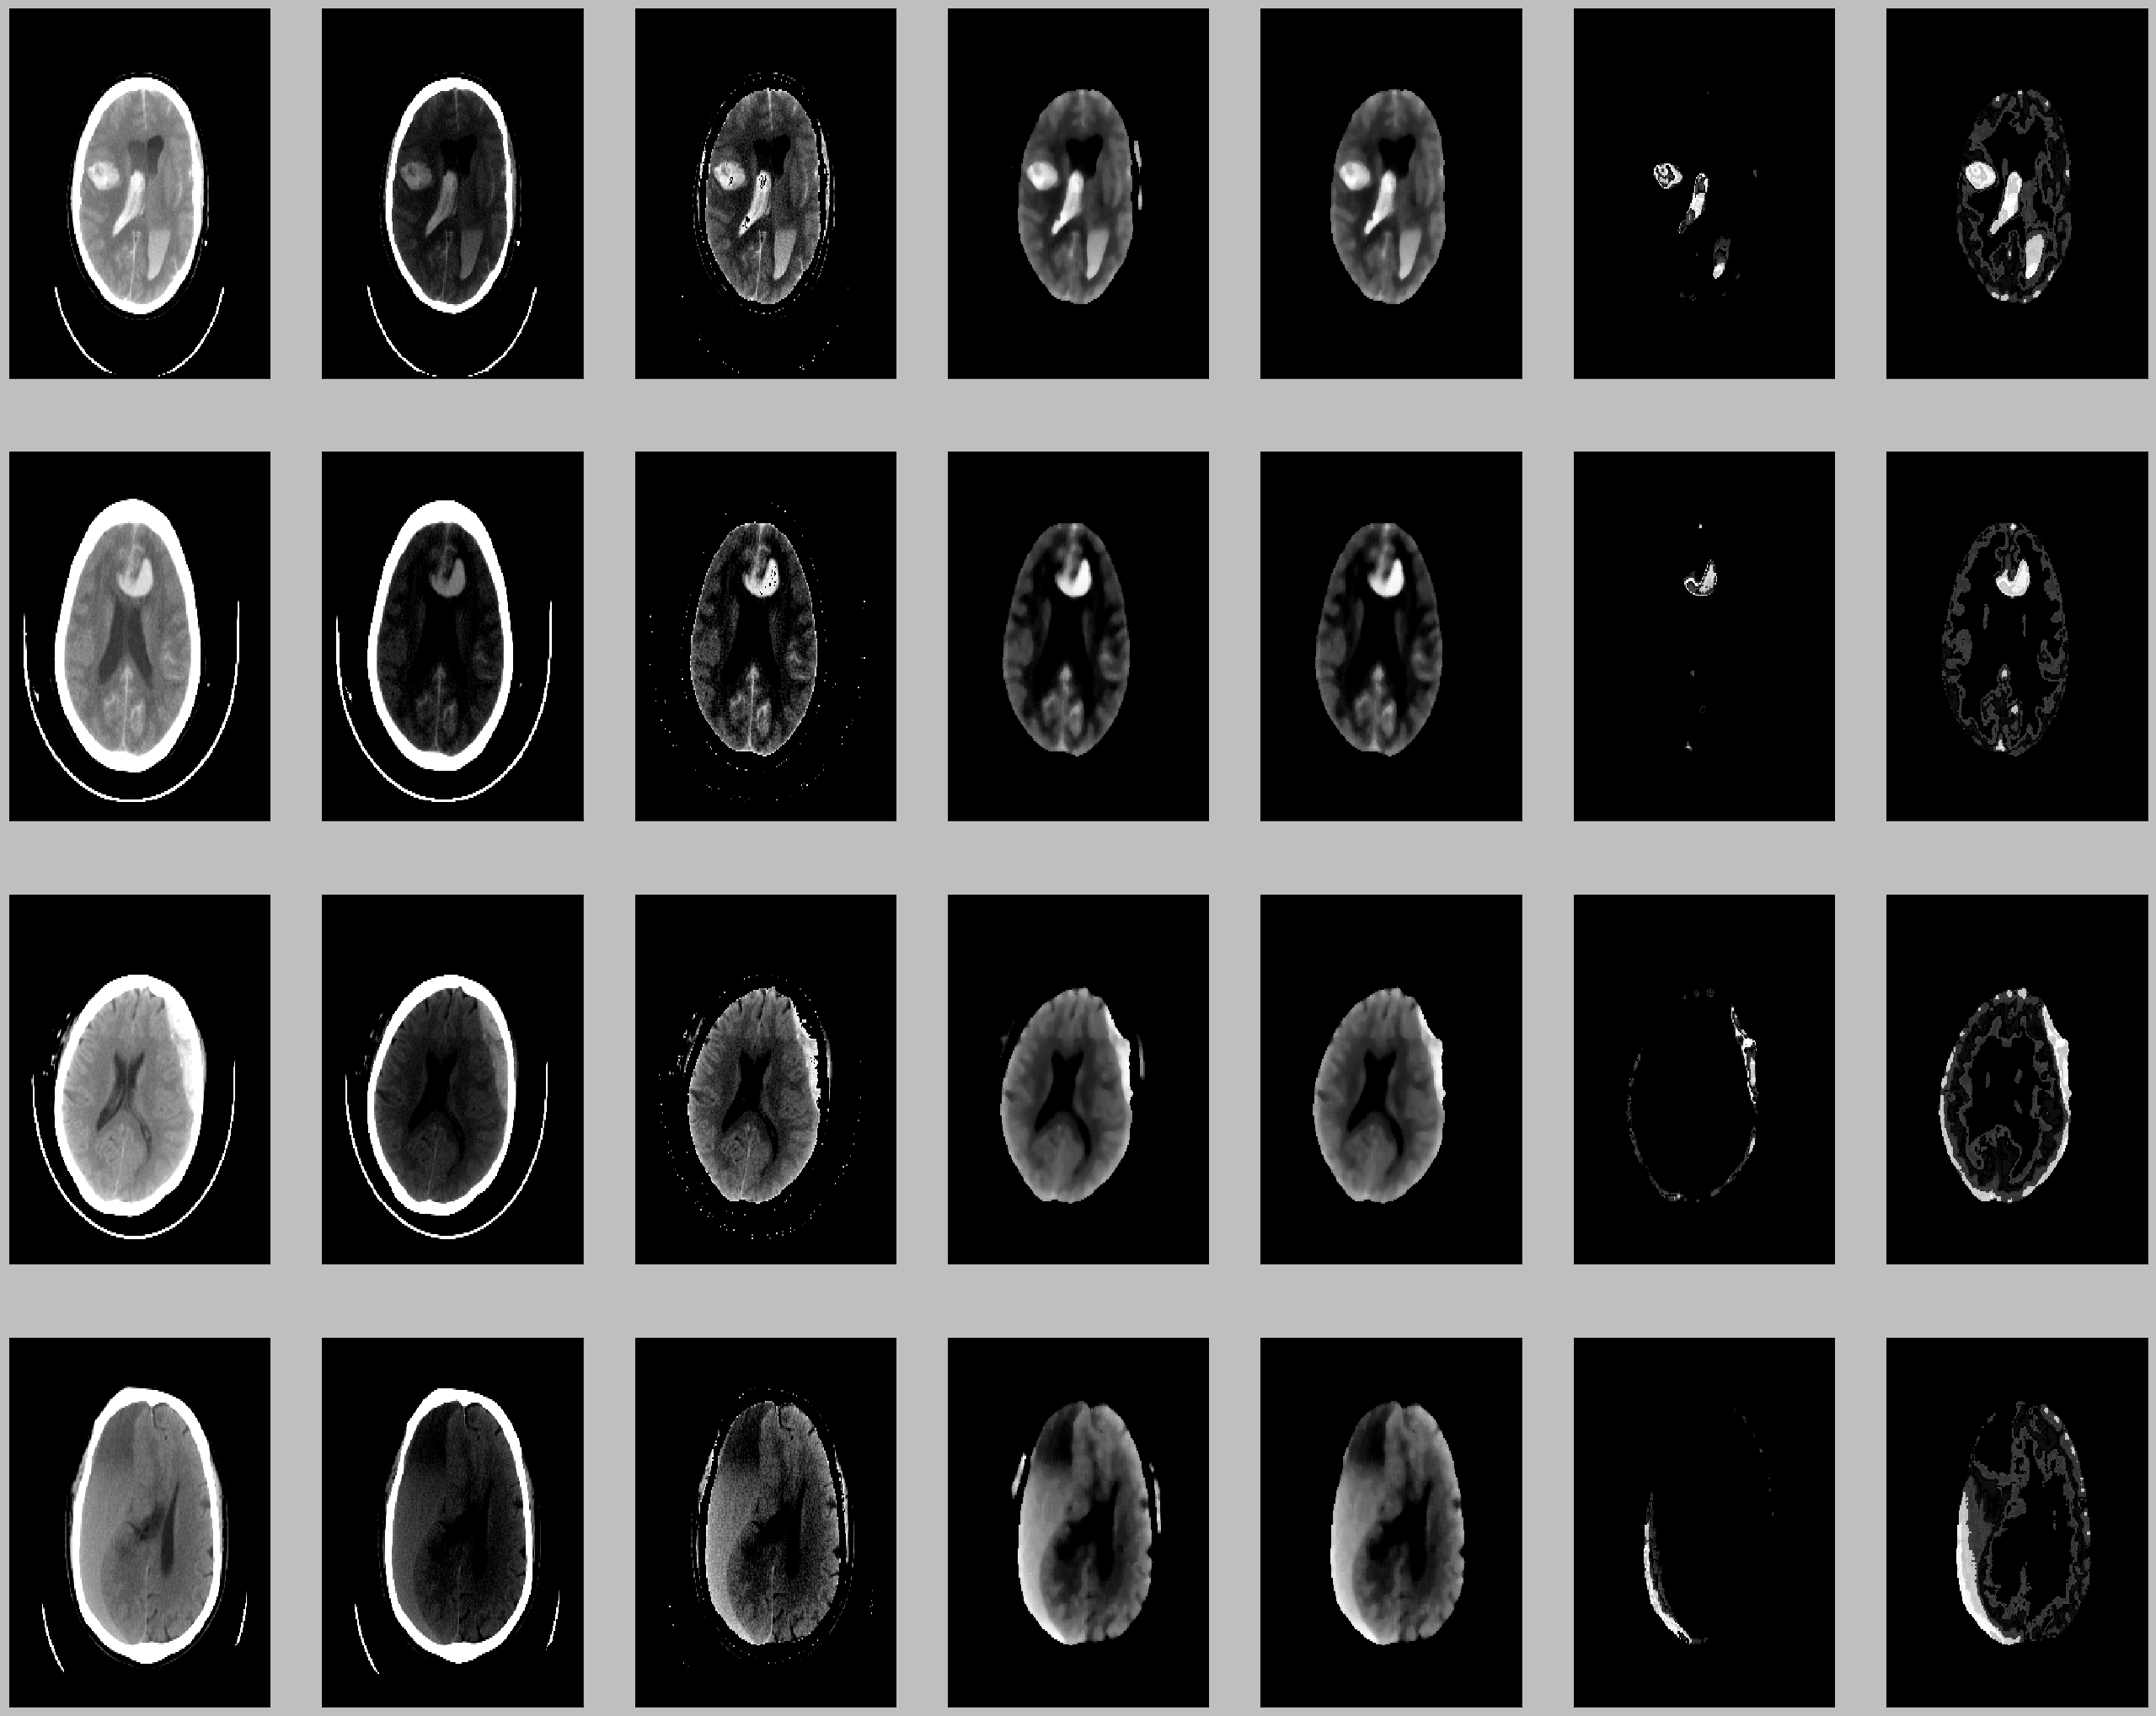

In [39]:
### HEMORRAGIAS ESCURA
# p =  "/home/rodrigo/processed-dataset/214/dicoms/CT_55mm_Plain/CT23.dcm"
# p1 =  "/home/rodrigo/processed-dataset/19/dicoms/CT_Plain/CT13.dcm"
# p2 =  "/home/rodrigo/processed-dataset/107/dicoms/CT_55mm_Plain-2/CT14.dcm"
# p3 =  "/home/rodrigo/processed-dataset/452/dicoms/CT_Plain/CT14.dcm"
# png =  "/home/rodrigo/processed-dataset/214/pngs/CT23.png"
# png1 = "/home/rodrigo/labels-tcc/19/CT13.png"
# png2 = "/home/rodrigo/labels-tcc/107/CT14.png"
# png3 = "/home/rodrigo/labels-tcc/452/CT14.png"
### HEMORRAGIAS CLARAS
p = "/home/rodrigo/processed-dataset/1/dicoms/CT_2.55mm/CT17.dcm"
p1 =  "/home/rodrigo/processed-dataset/19/dicoms/CT_Plain/CT16.dcm"
p2 =  "/home/rodrigo/processed-dataset/181/dicoms/CT_5mm/CT17.dcm"
p3 =  "/home/rodrigo/processed-dataset/274/dicoms/CT_55mm_Plain/CT21.dcm"
png = "/home/rodrigo/labels-tcc/1/CT17.png"
png1 = "/home/rodrigo/labels-tcc/19/CT16.png"
png2 = "/home/rodrigo/labels-tcc/181/CT17.png"
png3 = "/home/rodrigo/labels-tcc/274/CT21.png"

p = [p, p1, p2, p3]
png = [png, png1, png2, png3]

## PARAMETERS ESCURAS
# ww = 47; wl = 110; m_filter = 3; b_ww = 80; b_wl = 80; b_low = 120; b_upp = 260; thresh_a = 100; thresh_b = 180;
## PARAMETERS CLARAS
ww = 70; wl = 100; m_filter = 5; b_ww = 70; b_wl = 50; b_low = 120; b_upp = 260; thresh_a = 65; thresh_b = 150;
lista = []

for i in range(len(p)):
    lista.extend([cv2.imread(png[i])])
    original, no_bone, median, no_tissues = full_slice_process(p[i], ww, wl, m_filter, b_ww, b_wl, b_low, b_upp)
#     plot_histogram(generate_histogram(no_tissues))

    # SEGMENTATION
    #     bin_thresh = cv2.adaptiveThreshold(no_tissues,135,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    retval2,bin_thresh2 = cv2.threshold(no_tissues,30,85,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ret3,bin_thresh = cv2.threshold(no_tissues,thresh_a, thresh_b,cv2.THRESH_BINARY)
    binary = np.bitwise_and(no_tissues, bin_thresh, bin_thresh)
    binary2 = np.bitwise_and(no_tissues, bin_thresh2, bin_thresh2)
    
    lista.extend([original, no_bone, median, no_tissues, binary, binary2])
    
# plt.imshow(binary, 'gray')

### PLOTS
# n = 28
# for i in range(n):
#     plt.subplot(4,7,i+1)
#     plt.imshow(lista[i],'gray', aspect='auto')
#     plt.xticks([]), plt.yticks([])
#     plt.subplots_adjust(bottom=1.5, right=6.0, top=8.5)

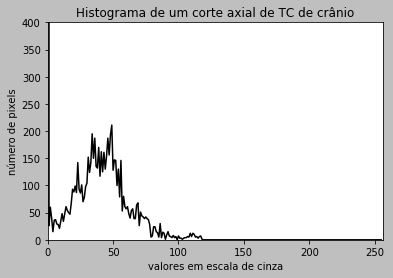

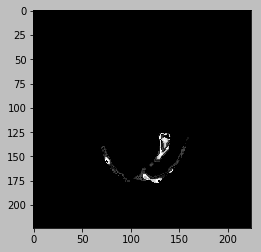

In [7]:
### DCM PATH
### IHC, IPH, SAH
# p = "/home/rodrigo/processed-dataset/1/dicoms/CT_2.55mm/CT17.dcm"
### IHC, IPH, EDH
# p =  "/home/rodrigo/processed-dataset/4/dicoms/CT_5mm/CT16.dcm"
### IHC
p = "/home/rodrigo/samples-tcc/159/dicoms/CT11.dcm"
### IHC, EDH, SAH
# p =  "/home/rodrigo/processed-dataset/181/dicoms/CT_5mm/CT17.dcm"
### SADIO
# p =  "/home/rodrigo/processed-dataset/214/dicoms/CT_55mm_Plain/CT23.dcm"
### IHC, SDH
# p =  "/home/rodrigo/processed-dataset/274/dicoms/CT_55mm_Plain/CT21.dcm"

## ESCURAS
# p =  "/home/rodrigo/processed-dataset/214/dicoms/CT_55mm_Plain/CT23.dcm"
# p =  "/home/rodrigo/processed-dataset/19/dicoms/CT_Plain/CT13.dcm"
# p =  "/home/rodrigo/processed-dataset/107/dicoms/CT_55mm_Plain-2/CT14.dcm"
# p =  "/home/rodrigo/processed-dataset/452/dicoms/CT_Plain/CT14.dcm"
# p =  "/home/rodrigo/processed-dataset/446/dicoms/CT_Plain/CT14.dcm"
# p =  "/home/rodrigo/processed-dataset/452/dicoms/CT_Plain/CT14.dcm"
# p =  "/home/rodrigo/processed-dataset/305/dicoms/CT_55mm_Plain/CT35.dcm"


## PARAMETERS CLARAS
ww = 70; wl = 100; m_filter = 5; b_ww = 70; b_wl = 50; b_low = 120; b_upp = 260;
## PARAMETERS ESCURAS
# ww = 47; wl = 110; m_filter = 3; b_ww = 80; b_wl = 80; b_low = 120; b_upp = 260;

pyplot.style.use('grayscale')

original, no_bone, median, no_tissues = full_slice_process(p, ww, wl, m_filter, b_ww, b_wl, b_low, b_upp)

hist = generate_histogram(median)
plot_histogram(hist)
save_histogram(hist, "/home/rodrigo/Projects/TCC/histograms/", "median-159.png")

ret3,bin_thresh = cv2.threshold(no_tissues,65,150,cv2.THRESH_BINARY)
binary = np.bitwise_and(no_tissues, bin_thresh, bin_thresh)
lista = [original, no_bone, no_tissues, binary]
plt.imshow(binary, 'gray')
### PLOTS
n = 4
# for i in range(n):
#     plt.subplot(4,4,i+1)
#     plt.imshow(lista[i],'gray', aspect='auto')
#     plt.xticks([]), plt.yticks([])
#     plt.subplots_adjust(bottom=1.5, right=6.0, top=8.5)

In [8]:
directory = "/home/rodrigo/Projects/TCC/resultados/"
cv2.imwrite(directory + "274-proceessado.jpg", binary)

True

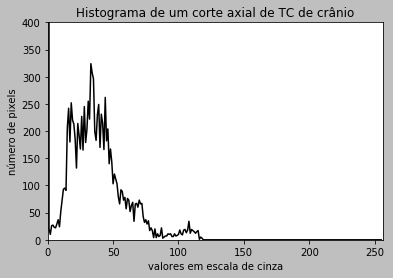

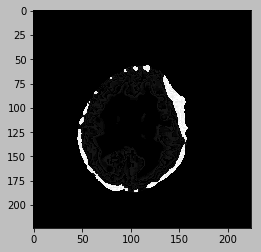

In [51]:
### HEMORRAGIAS CLARAS
p2 =  "/home/rodrigo/processed-dataset/181/dicoms/CT_5mm/CT17.dcm"
png2 = "/home/rodrigo/labels-tcc/181/CT17.png"

ww = 70; wl = 100; m_filter = 5; b_ww = 70; b_wl = 50; b_low = 120; b_upp = 260; thresh_a = 65; thresh_b = 150;
lista = []

lista.extend([cv2.imread(png2)])
original, no_bone, median, no_tissues = full_slice_process(p2, ww, wl, m_filter, b_ww, b_wl, b_low, b_upp)
plot_histogram(generate_histogram(no_tissues))

# SEGMENTATION
#     bin_thresh = cv2.adaptiveThreshold(no_tissues,135,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
retval2,bin_thresh2 = cv2.threshold(no_tissues,25,70,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret3,bin_thresh = cv2.threshold(no_tissues,thresh_a, thresh_b,cv2.THRESH_BINARY)
binary = np.bitwise_and(no_tissues, bin_thresh, bin_thresh)
binary2 = np.bitwise_and(no_tissues, bin_thresh2, bin_thresh2)

lista.extend([original, binary, binary2])
    
plt.imshow(binary2, 'gray')
# cv2.imwrite('/home/rodrigo/Projects/TCC/histograms/plot1.png', binary)
